In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
from mlrl.runners.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.meta.meta_policies.random_policy import create_random_search_policy, create_random_search_policy_no_terminate
from mlrl.meta.meta_policies.terminator_policy import TerminatorPolicy
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network
from mlrl.experiments.procgen_meta import reset_object_level_metrics, get_object_level_metrics

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


In [3]:
percentile = 0.75
max_tree_size = 64

args = {
    'pretrained_runs_folder': 'runs',
    'pretrained_run': 'run-16823527592836354',
    'pretrained_percentile': percentile,
    'expand_all_actions': True,
    'finish_on_terminate': True,
    'max_tree_size': max_tree_size,
}

object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.75),
    verbose=False
)

In [9]:
from tensorflow.keras.utils import Progbar
from mlrl.meta.meta_env import MetaEnv
from mlrl.experiments.procgen_meta import reset_object_level_metrics, get_object_level_metrics

n_envs = 1
batched_meta_env = create_batched_procgen_meta_envs(n_envs=n_envs, object_config=object_config, **args)

n_object_level_episodes = 10

prog_bar = Progbar(
    n_object_level_episodes,
    unit_name='episode',
    stateful_metrics=list(get_object_level_metrics(batched_meta_env).keys())
)

class ObjectLevelMetric:

    def __init__(self, name: str, result: float):
        self.name = name
        self.res = result
    
    def result(self):
        return self.res


def completed_n_object_level_episodes(n: int) -> bool:
    n_complete = sum([
        env.object_level_metrics.get_num_episodes()
        for env in batched_meta_env.envs
    ])

    metrics = get_object_level_metrics(batched_meta_env)
    prog_bar.update(n_complete, values=metrics.items())

    return n_complete >= n

eval_runner = EvalRunner(
    eval_env=batched_meta_env,
    policy=TerminatorPolicy(batched_meta_env),
    rewrite_rewards=True,
    use_tf_function=False,
    stop_eval_condition=lambda: completed_n_object_level_episodes(n_object_level_episodes),
)

from mlrl.procgen.time_limit_observer import TimeLimitObserver

episode_stats = []
for env in batched_meta_env.envs:
    env.object_level_transition_observers.append(TimeLimitObserver(env, 500))
    env.object_level_metrics.episode_complete_callback = episode_stats.append

In [10]:
batched_meta_env.reset()
reset_object_level_metrics(batched_meta_env)

eval_runner.run()

10/10 [==============================] - 39s 3s/episode - ObjectLevelMeanReward: 30.6000 - ObjectLevelMeanStepsPerEpisode: 233.5000 - ObjectLevelEpisodes: 10.0000
Evaluation stats:
EvalTime: 36.501


{'EvalRewrittenAverageReturn': 0.0,
 'EvalNumberOfEpisodes': 2344,
 'EvalEnvironmentSteps': 2344,
 'EvalAverageReturn': 0.0,
 'EvalAverageEpisodeLength': 1.0,
 'EvalTime': 36.50141167640686}

In [11]:
get_object_level_metrics(batched_meta_env)

{'ObjectLevelMeanReward': 30.6,
 'ObjectLevelMeanStepsPerEpisode': 233.5,
 'ObjectLevelEpisodes': 10}

In [12]:
episode_stats

[{'return': 83.0, 'steps': 500},
 {'return': 40.0, 'steps': 295},
 {'return': 47.0, 'steps': 346},
 {'return': 2.0, 'steps': 46},
 {'return': 3.0, 'steps': 34},
 {'return': 7.0, 'steps': 80},
 {'return': 4.0, 'steps': 77},
 {'return': 44.0, 'steps': 285},
 {'return': 14.0, 'steps': 187},
 {'return': 62.0, 'steps': 485}]

In [ ]:
{'ObjectLevelMeanReward': 42.2,
 'ObjectLevelMeanStepsPerEpisode': 916.6,
 'ObjectLevelEpisodes': 10}

In [6]:
def print_root_q_dist(policy, message: str):
    estimator = policy.estimator
    tree = policy.tree
    state = tree.root_node.state
    q_dist = estimator.estimate_optimal_q_distribution(tree, state)
    q_dist = {state.get_action_label(a): v for a, v in q_dist.items()}
    q_dist_str = '\n'.join([f'\t- Q({a}) = {v}' for a, v in q_dist.items()])
    print(f'{message} Q-distribution:\n{q_dist_str}')

def print_rewritten_info(rewritten_trajs: list):
    for env_idx in range(2):
        print(f'Env {env_idx}')
        computational_return = 0
        for i, (traj, info) in enumerate(rewritten_trajs):
            info = {k: v[env_idx] for k, v in info.items()}
            if i == 0:
                prev_policy_value = info['prev_policy_value']
                prev_policy = info['prev_policy']
                policy_str = prev_policy.__repr__(sep=' ')
                print(f'Initial policy: {policy_str} \t policy_value = {prev_policy_value:.3f}')
                print_root_q_dist(prev_policy, 'Initial')
                print()

            elif traj.is_last()[env_idx]:
                print()
                policy_str = policy.__repr__(sep=' ')
                print(f'Final policy: {policy_str} \t policy_value = {policy_value:.3f}')
                print_root_q_dist(policy, 'Final')
            
            else:
                policy = info['policy']
                policy_value = info['policy_value']
                computational_reward = info['computational_reward']
                computational_return += computational_reward
                policy_str = policy.__repr__(sep=' ')
                print(f'{computational_reward = :.3f} \t {computational_return = :.3f} \t {policy_value = :.3f}  \t {policy_str}')
        print()


In [7]:
from IPython.display import clear_output
from tf_agents.trajectories import trajectory
from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter


rewritten_trajs = []
rewards_rewriter = RetroactiveRewardsRewriter(
    batched_meta_env, rewritten_trajs.append, include_info=True, compute_metrics=False
)

try:
    time_step = batched_meta_env.reset()

    while not time_step.is_last()[0]:
        time_step = batched_meta_env.current_time_step()
        action_step = a_star.action(time_step)
        next_time_step = batched_meta_env.step(action_step.action)
        
        action_step_with_previous_state = action_step._replace(state=())
        traj = trajectory.from_transition(
            time_step, action_step_with_previous_state, next_time_step)

        rewards_rewriter(traj)

        # batched_meta_env.envs[0].render(plt_show=True)
        # clear_output(wait=True)

    print_rewritten_info(rewritten_trajs)


except KeyboardInterrupt:
    pass

Env 0
Initial policy: Greedy Policy Trajectory: LEFT+UP 	 policy_value = 24.256
Initial Q-distribution:
	- Q(LEFT+DOWN) = 24.260120391845703
	- Q(LEFT) = 24.265640258789062
	- Q(LEFT+UP) = 24.37489128112793
	- Q(DOWN) = 24.20737075805664
	- Q(UP) = 24.364089965820312
	- Q(RIGHT+DOWN) = 24.17626190185547
	- Q(RIGHT) = 24.278888702392578
	- Q(RIGHT+UP) = 24.32773208618164

computational_reward = -0.234 	 computational_return = -0.234 	 policy_value = 24.132  	 Greedy Policy Trajectory: UP UP UP
computational_reward = 0.000 	 computational_return = -0.234 	 policy_value = 24.132  	 Greedy Policy Trajectory: UP UP UP RIGHT+UP
computational_reward = -0.022 	 computational_return = -0.257 	 policy_value = 24.109  	 Greedy Policy Trajectory: UP UP RIGHT+UP UP
computational_reward = 0.036 	 computational_return = -0.221 	 policy_value = 24.145  	 Greedy Policy Trajectory: UP UP LEFT+UP RIGHT+UP
computational_reward = 0.266 	 computational_return = 0.045 	 policy_value = 24.411  	 Greedy Policy

In [35]:
eval_runner = EvalRunner(
    eval_steps=5000 * n_envs,
    eval_env=batched_meta_env,
    policy=a_star,
    rewrite_rewards=True,
    use_tf_function=False
)

In [36]:
eval_runner.run()

10000/10000 [==============================] - 311s 31ms/step - AverageReturn: 3.1270
Evaluation stats:
EvalFinalPolicyValue: 28.295, EvalTime: 310.512


{'EvalRewrittenAverageReturn': 0.43925056,
 'EvalFinalPolicyValue': 28.295199111720542,
 'EvalNumberOfEpisodes': 1110,
 'EvalEnvironmentSteps': 10000,
 'EvalAverageReturn': 2.948624,
 'EvalAverageEpisodeLength': 9.0,
 'EvalTime': 310.5118043422699}

In [14]:
procgen_env = batched_meta_env.envs[0].object_env

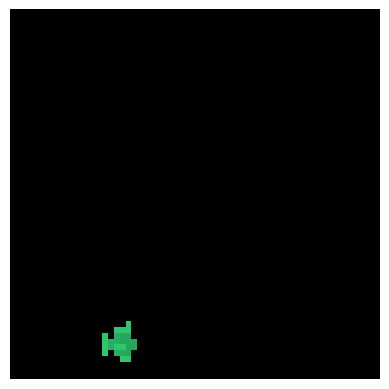

In [23]:
procgen_env.step(0)
ts = procgen_env.step(-1)
plt.imshow(procgen_env.render(mode='rgb_array'))
plt.axis('off')
plt.show()

In [43]:
batched_meta_env.envs[0].object_level_metrics.return_val, batched_meta_env.envs[0].object_level_metrics.n_steps

(88.0, 704)

In [42]:
batched_meta_env.envs[0].object_level_metrics.episode_stats

[{'return': 61.0, 'steps': 270}]

In [45]:
traj.get_info()

{'original_reward': array([-0.02317144, -0.04498545]),
 'prev_policy': {0: Greedy Policy Trajectory: ,
  1: Greedy Policy Trajectory: LEFT+UPLEFT+UP},
 'policy': {0: Greedy Policy Trajectory: ,
  1: Greedy Policy Trajectory: LEFT+UPLEFT+UP},
 'eval_tree': {0: None, 1: None},
 'terminal': [<tf.Tensor: shape=(), dtype=bool, numpy=False>,
  <tf.Tensor: shape=(), dtype=bool, numpy=False>]}

In [3]:
from typing import Dict

import pandas as pd


def test_policies_with_pretrained_model(policy_creators: Dict[str, callable],
                                        percentile=0.75,
                                        eval_steps_per_env=1000,
                                        max_tree_size=32,
                                        n_envs=16,
                                        results_observer: callable = None):

    args = {
        'pretrained_runs_folder': 'runs',
        'pretrained_run': 'run-16823527592836354',
        'pretrained_percentile': percentile,
        'expand_all_actions': True,
        'finish_on_terminate': True,
        'max_tree_size': max_tree_size,
    }

    object_config = load_pretrained_q_network(
        folder=args['pretrained_runs_folder'],
        run=args['pretrained_run'],
        percentile=args.get('pretrained_percentile', 0.75),
        verbose=False
    )


    results = []
    for policy_name, create_policy in policy_creators.items():

        batched_meta_env = create_batched_procgen_meta_envs(n_envs=n_envs, object_config=object_config, **args)

        eval_runner = EvalRunner(
            eval_steps=eval_steps_per_env * n_envs,
            eval_env=batched_meta_env,
            policy=create_policy(batched_meta_env),
            rewrite_rewards=True,
            use_tf_function=False
        )

        print(f'Evaluating {policy_name}')
        reset_object_level_metrics(batched_meta_env)
        eval_results = eval_runner.run()
        object_level_results = get_object_level_metrics(batched_meta_env)

        evaluations = {
            'Meta-level Policy': policy_name,
            **args,
            **object_config,
            **eval_results,
            **object_level_results
        }
        if results_observer is not None:
            results_observer(evaluations)

        results.append(evaluations)
    
    return results

In [4]:
policy_creators = {
    'AStar': AStarPolicy,
    'Random': create_random_search_policy,
    'RandomNoTerminate': create_random_search_policy_no_terminate,
    'Terminator': TerminatorPolicy
}

evaluations = []
for percentile in [0.25, 0.5, 0.75, 0.9]:
    print(f'Evaluating with pretrained model at return {percentile = }')
    # evaluations += test_policies_with_pretrained_model(
    #     policy_creators, percentile=percentile, eval_steps_per_env=1000, max_tree_size=64
    # )
    evaluations += test_policies_with_pretrained_model(
        policy_creators, percentile=percentile, eval_steps_per_env=10, max_tree_size=10
    )

Evaluating with pretrained model at return percentile = 0.25


/tmp/__autograph_generated_filew6vhht03.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  retval_ = ag__.and_((lambda : (ag__.ld(state) is not None)), (lambda : ag__.and_((lambda : (ag__.ld(state) is not ())), (lambda : (ag__.ld(state) is not [])))))


Evaluating AStar
160/160 [==============================] - 1s 5ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalTime: 0.732
Evaluating Random
167/160 [===============================] - 2s 15ms/step - AverageReturn: -0.0671
Evaluation stats:
EvalFinalPolicyValue: 17.391, EvalTime: 2.426
Evaluating RandomNoTerminate
168/160 [===============================] - 2s 13ms/step - AverageReturn: -0.0413
Evaluation stats:
EvalFinalPolicyValue: 17.090, EvalTime: 2.129
Evaluating Terminator
160/160 [==============================] - 2s 10ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalTime: 1.548
Evaluating with pretrained model at return percentile = 0.5
Evaluating AStar
160/160 [==============================] - 1s 5ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalTime: 0.842
Evaluating Random
170/160 [===============================] - 2s 14ms/step - AverageReturn: 0.0202
Evaluation stats:
EvalFinalPolicyValue: 20.611, EvalTime: 2.362
Evaluating RandomNoTerminate
1

In [5]:
evaluations_df = pd.DataFrame(evaluations)
evaluations_df

,Meta-level Policy,pretrained_runs_folder,pretrained_run,pretrained_percentile,expand_all_actions,finish_on_terminate,max_tree_size,action_repeats,agent_name,collect_steps_per_iteration,...,EvalRewrittenAverageReturn,EvalNumberOfEpisodes,EvalEnvironmentSteps,EvalAverageReturn,EvalAverageEpisodeLength,EvalTime,ObjectLevelMeanReward,ObjectLevelMeanStepsPerEpisode,ObjectLevelEpisodes,EvalFinalPolicyValue
0,AStar,runs,run-16823527592836354,0.25,True,True,10,4,categorical_dqn_agent,1,...,0.0,0,160,0.0,0.0,0.731505,0.000000,0.000000,16,NaN
1,Random,runs,run-16823527592836354,0.25,True,True,10,4,categorical_dqn_agent,1,...,0.0,75,167,-0.158118,1.653333,2.426397,0.250000,7.312500,16,17.390825
2,RandomNoTerminate,runs,run-16823527592836354,0.25,True,True,10,4,categorical_dqn_agent,1,...,0.0,59,168,-0.072741,2.254237,2.128976,0.187500,6.687500,16,17.089727
3,Terminator,runs,run-16823527592836354,0.25,True,True,10,4,categorical_dqn_agent,1,...,0.0,160,160,0.0,1.0,1.548234,0.352941,9.411765,17,NaN
4,AStar,runs,run-16823527592836354,0.50,True,True,10,4,categorical_dqn_agent,1,...,0.0,0,160,0.0,0.0,0.841835,0.000000,0.062500,16,NaN
5,Random,runs,run-16823527592836354,0.50,True,True,10,4,categorical_dqn_agent,1,...,-0.026162,92,170,0.013639,1.271739,2.362114,0.312500,8.687500,16,20.611193
6,RandomNoTerminate,runs,run-16823527592836354,0.50,True,True,10,4,categorical_dqn_agent,1,...,0.0,51,160,-0.003368,1.960784,1.968114,0.125000,6.000000,16,20.590088
7,Terminator,runs,run-16823527592836354,0.50,True,True,10,4,categorical_dqn_agent,1,...,0.0,160,160,0.0,1.0,1.531472,0.250000,10.000000,16,NaN
8,AStar,runs,run-16823527592836354,0.75,True,True,10,4,categorical_dqn_agent,1,...,0.0,0,160,0.0,0.0,1.043827,0.000000,0.000000,16,NaN
9,Random,runs,run-16823527592836354,0.75,True,True,10,4,categorical_dqn_agent,1,...,0.0,66,162,0.017683,1.878788,2.030701,0.187500,6.562500,16,24.739346


In [6]:
evaluations_df.to_csv('outputs/baselines/procgen/meta-evaluations-longer-run.csv')

In [7]:
evaluations_df.columns

Index(['Meta-level Policy', 'pretrained_runs_folder', 'pretrained_run',
       'pretrained_percentile', 'expand_all_actions', 'finish_on_terminate',
       'max_tree_size', 'action_repeats', 'agent_name',
       'collect_steps_per_iteration', 'discount', 'env', 'epsilon',
       'epsilon_decay_steps', 'epsilon_schedule', 'eval_steps',
       'experience_batch_size', 'final_epsilon', 'frame_stack', 'grayscale',
       'initial_collect_steps', 'initial_epsilon', 'learning_rate',
       'max_epochs', 'metrics', 'model_config', 'n_collect_envs',
       'n_eval_envs', 'n_video_envs', 'name', 'optimiser_config',
       'procgen_env_name', 'replay_buffer_capacity', 'run_dir',
       'target_network_update_period', 'train_steps_per_epoch',
       'video_seconds', 'pretrained_epoch', 'pretrained_return',
       'pretrained_path', 'EvalRewrittenAverageReturn', 'EvalNumberOfEpisodes',
       'EvalEnvironmentSteps', 'EvalAverageReturn', 'EvalAverageEpisodeLength',
       'EvalTime', 'ObjectLevelMe

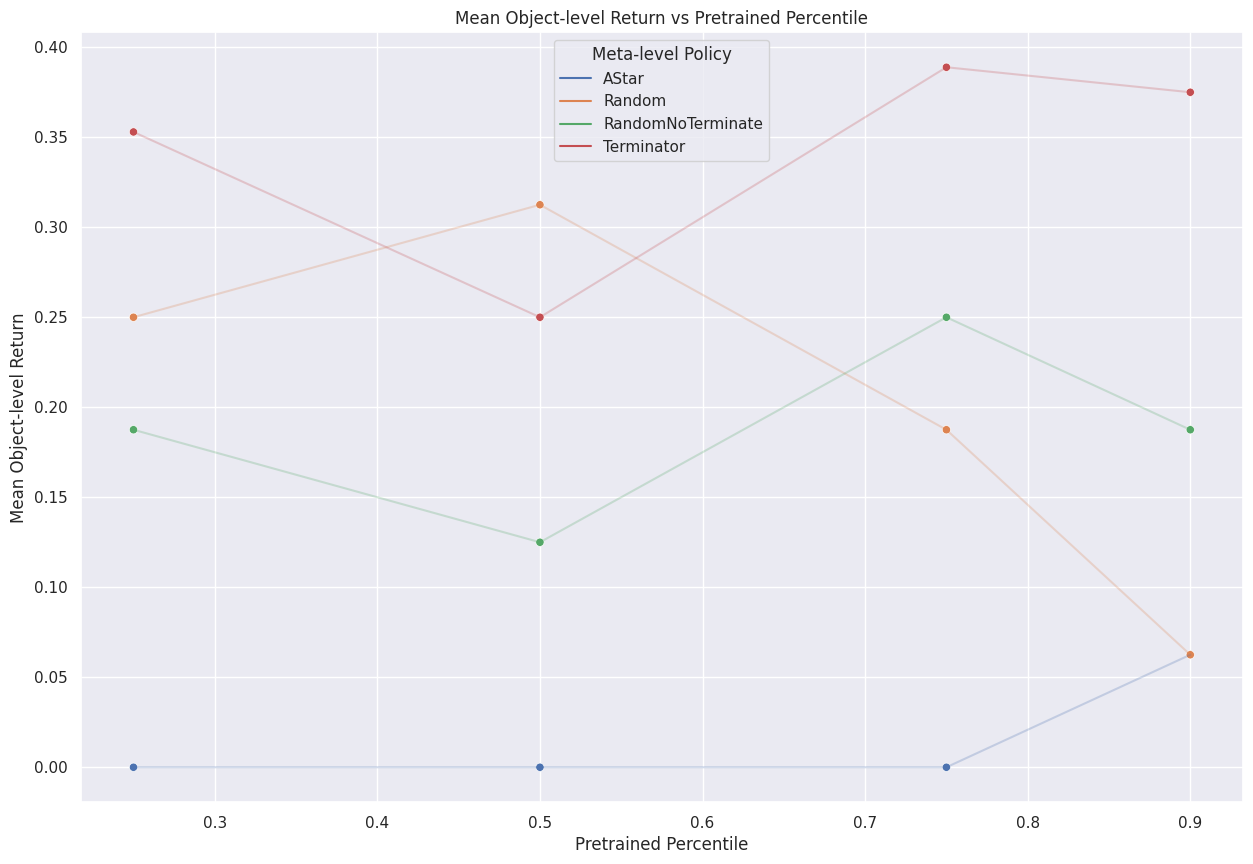

In [8]:
plots = {
    'Mean Object-level Return': 'ObjectLevelMeanReward',
    # 'Mean Object-level Steps Per Episode': 'ObjectLevelMeanStepsPerEpisode',
    # 'Object-level Episodes': 'ObjectLevelEpisodes',
}

for plot_name, plot_key in plots.items():
    plt.figure(figsize=(15, 10))

    # sns.lineplot(data=evaluations_df, x='pretrained_percentile', y='pretrained_return', label='Pretrained Return', alpha=0.25, color='r')
    sns.lineplot(data=evaluations_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)

    # sns.scatterplot(data=evaluations_df, x='pretrained_percentile', y='pretrained_return', color='r', legend=False)
    sns.scatterplot(data=evaluations_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', legend=False)

    plt.xlabel('Pretrained Percentile')
    plt.ylabel(plot_name)
    plt.title(f'{plot_name} vs Pretrained Percentile')
    plt.show()

In [11]:
from mlrl.runners.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.meta.meta_policies.random_policy import create_random_search_policy, create_random_search_policy_no_terminate
from mlrl.meta.meta_policies.terminator_policy import TerminatorPolicy


object_level_metrics = ObjectLevelMetrics()

args = {
    'pretrained_runs_folder': 'runs',
    'pretrained_run': 'run-16823527592836354',
    'pretrained_percentile': 0.75,
    'expand_all_actions': True,
    'collect_steps_per_iteration': 16,
    'finish_on_terminate': True,
    'max_tree_size': 64,
    'object_level_transition_observers': [object_level_metrics]
}


object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.5),
    verbose=False
)

batched_meta_env = create_batched_procgen_meta_envs(n_envs=2, object_config=object_config, **args)

object_level_metrics.reset()

In [11]:
from mlrl.utils.render_utils import embed_mp4

fps = 1

eval_runner = EvalRunner(
    eval_steps=1000,
    eval_env=batched_meta_env,
    policy=AStarPolicy(batched_meta_env),
    rewrite_rewards=True,
    use_tf_function=False
)

embed_mp4(eval_runner.create_policy_eval_video(60 * fps, fps=fps))

In [14]:
from mlrl.experiments.procgen_meta import create_runner

In [15]:
runner = create_runner(args)

Building Categorical Q-Network weights...
Initializing Rainbow agent...
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_7_15.672922', 7, 15.672922)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_6_13.709443', 6, 13.709443)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_21_21.514286', 21, 21.514286)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_22_25.023256', 22, 25.023256)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_38_28.903225', 38, 28.903225)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_4_12.972549', 4, 12.972549)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_23_27.598986', 23, 27.598986)
('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_60_37.204189', 60, 37.204189)
('runs/categorical_dqn_agent/run-1682352759283

/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("E